In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(512, 512)

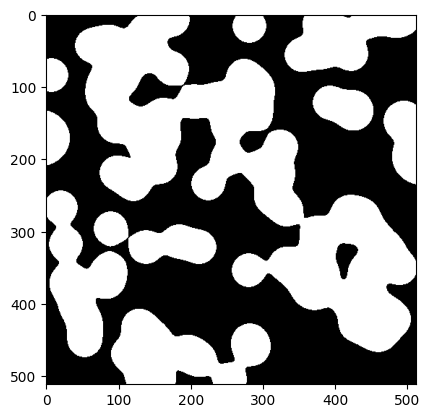

In [127]:
import skimage as sk
import matplotlib.pyplot as plt

I_binary = sk.data.binary_blobs()

I = I_binary.astype(np.uint8) #0 and 1

plt.imshow(I, cmap='gray')

I.shape  #grayscale

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

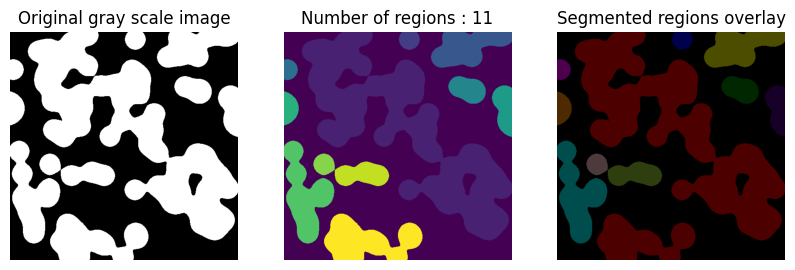

In [128]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb

# thresh = threshold_otsu(I)
# I_bw = I > thresh

# plt.imshow(I_bw, cmap='gray')

label_image, nregions = label(I,return_num=True)
# plt.imshow(label_image)

image_label_overlay = label2rgb(label_image,image=I)
# plt.imshow(image_label_overlay)

fig,ax = plt.subplots(1,3,figsize=(10,7))

ax[0].imshow(I, cmap='gray')
ax[0].set_title('Original gray scale image')

ax[1].imshow(label_image)
ax[1].set_title('Number of regions : {}'.format(nregions))

ax[2].imshow(image_label_overlay)
ax[2].set_title('Segmented regions overlay')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [129]:
from skimage.measure import regionprops, regionprops_table
import numpy as np
import pandas as pd

# props = regionprops(label_image)
# features = np.zeros((nregions,5))

# for i in range(0,nregions):
#   features[i,0] = props[i].label # or int(i)
#   features[i,1] = props[i].area
#   features[i,2] = props[i].eccentricity
#   features[i,3] = props[i].extent
#   features[i,4] = props[i].axis_major_length

# df = pd.DataFrame(features, columns=['label','area','eccentricity','extent','axis_major_length'])
# df

props = regionprops_table(label_image, properties=['label','area','eccentricity','axis_major_length'])
df_features = pd.DataFrame(props)
df_features.head()

,label,area,eccentricity,axis_major_length
0,1,75322.0,0.945398,679.010001
1,2,1543.0,0.494523,47.780294
2,3,9784.0,0.909431,184.521973
3,4,1192.0,0.740759,48.435684
4,5,3823.0,0.784498,89.123150


<Axes: xlabel='axis_major_length', ylabel='area'>

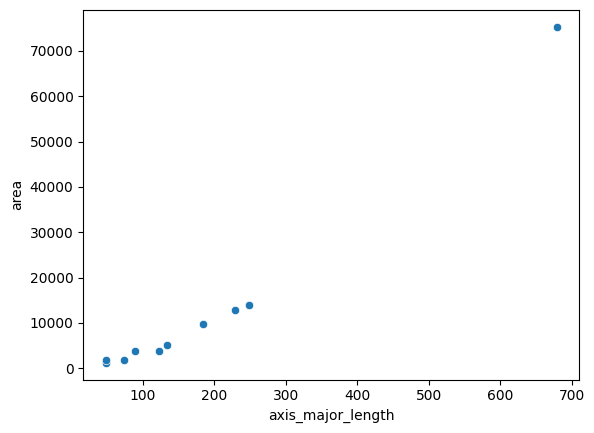

In [130]:
import seaborn as sns

sns.scatterplot(x='axis_major_length',y='area',data=df_features)

Key observations:

There is a positive correlation between the two variables—as the major axis length increases, the area also tends to increase.

The point distribution suggests that the relationship is not purely linear, with some deviations.

A few outliers are present, deviating from the general trend

In [131]:
avg_area = np.average(df_features['area'])

blobs1 = np.where(df_features['area'] > avg_area)
large_blobs = blobs1[0] + 1

# print(np.array(large_blobs))
print(avg_area)
print(np.size(large_blobs))

11915.636363636364
3


In [132]:
blobs2 = np.where(df_features['area'] < avg_area)
small_blobs = blobs2[0] + 1

# print(np.array(small_blobs))
print(avg_area)
print(np.size(small_blobs))

11915.636363636364
8


In [133]:
# find the labels of small and large blobs

#large blobs
labels_blobs1 = df_features['label'][df_features['area'] > avg_area].tolist()
# labels_blobs1 = df_features['label'][blobs1[0]].tolist()

#small blobs
labels_blobs2 = df_features['label'][df_features['area'] < avg_area].tolist()
# labels_blobs1 = df_features['label'][blobs2[0]].tolist()

print(labels_blobs1)
print(labels_blobs2)

[1, 8, 11]
[2, 3, 4, 5, 6, 7, 9, 10]


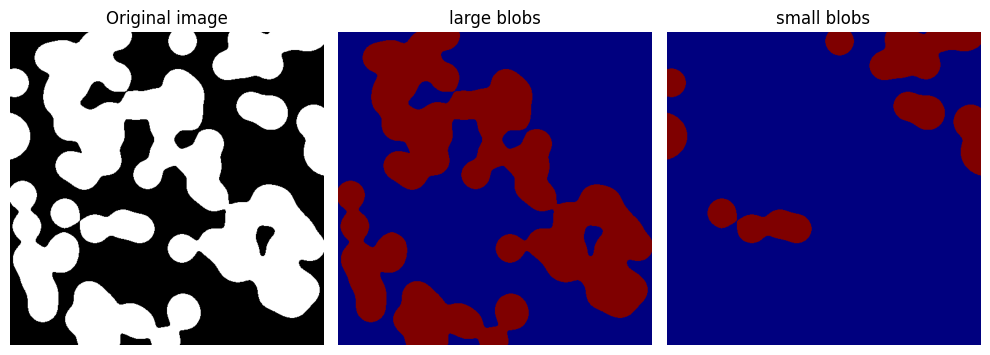

In [141]:
mask_blobs1 = np.zeros_like(label_image, dtype=np.uint8)

for idx in blobs1[0]:
  mask_blobs1[label_image == (idx+1)] = 1

#or
# for idx in large_blobs:
#   mask_blobs1[label_image == (idx)] = 1


mask_blobs2 = np.zeros_like(label_image, dtype=np.uint8)

for idx in blobs2[0]:
  mask_blobs2[label_image == (idx+1)] = 1


fig, axes = plt.subplots(1,3,figsize=(10, 7))
ax = axes.ravel()
ax[0].imshow(I,cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(mask_blobs1,cmap=plt.cm.jet)
ax[1].set_title('large blobs')

ax[2].imshow(mask_blobs2,cmap=plt.cm.jet)
ax[2].set_title('small blobs')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

In [138]:
#texture-based regional properties

from skimage.feature.texture import graycomatrix, graycoprops

g = graycomatrix(I,[1],[0],levels = 2, normed=False, symmetric=False) # value = 2 -> since the image has only 2 values (0 and 1), graycomatrix should calculate frequencies for all possible combinations

# Possible combinations (0→0, 0→1, 1→0, 1→1)
print('Frequency of 0 -> 0:', g[0, 0, 0, 0])
print('Frequency of 0 -> 1:', g[0, 1, 0, 0])
print('Frequency of 1 -> 0:', g[1, 0, 0, 0])
print('Frequency of 1 -> 1:', g[1, 1, 0, 0])

Frequency of 0 -> 0: 128995
Frequency of 0 -> 1: 1718
Frequency of 1 -> 0: 1710
Frequency of 1 -> 1: 129209


In [140]:
iregion = 0
props_texture = np.zeros((nregions,5))
props_list = regionprops(label_image) # Returns list of RegionProperties objects

for p in props_list:
  minr, minc, maxr, maxc = p.bbox
  img = I[minc:maxc, minr:maxr]  #subimage
  g = graycomatrix(img,[1],[0], levels=None, normed=True, symmetric=True)

  contrast = graycoprops(g, 'contrast')
  dissimilarity = graycoprops(g, 'dissimilarity')
  homogeneity = graycoprops(g, 'homogeneity')
  energy = graycoprops(g, 'energy')
  correlation = graycoprops(g, 'correlation')

  props_texture[iregion,0] = contrast
  props_texture[iregion,1] = dissimilarity
  props_texture[iregion,2] = homogeneity
  props_texture[iregion,3] = energy
  props_texture[iregion,4] = correlation

  iregion = iregion + 1

df = pd.DataFrame(props_texture,columns=['Contrast','Dissimilarity','Homogeneity','Energy','Correlation'])
df




<ipython-input-140-86150c966131>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,0] = contrast
<ipython-input-140-86150c966131>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,1] = dissimilarity
<ipython-input-140-86150c966131>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,2] = homogeneity
<ipython-input-140-86150c966131>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scala

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,0.013184,0.013184,0.993408,0.697853,0.973632
1,0.022913,0.022913,0.988543,0.851844,0.909065
2,0.018987,0.018987,0.990506,0.697194,0.961664
3,0.006311,0.006311,0.996844,0.704585,0.987308
4,0.015808,0.015808,0.992096,0.697721,0.968233
5,0.008696,0.008696,0.995652,0.880873,0.959638
6,0.013158,0.013158,0.993421,0.810650,0.960111
7,0.013120,0.013120,0.993440,0.699159,0.973666
8,0.020833,0.020833,0.989583,0.775617,0.944888
9,0.019277,0.019277,0.990361,0.751509,0.953696
